In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
%matplotlib inline
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

In [77]:
np.random.seed(42)

In [78]:
titanic_data = pd.read_csv('data/titanic/train.csv')

In [79]:
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis='columns')
X = pd.get_dummies(X)
X = X.fillna({'Age': X.Age.median()}) # Можно вместо медианы попробовать подругому подобрать более подходящие данные, напрмер через машинное обучение и предсказание.
y = titanic_data.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [80]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
cross_val_score(clf, X_train, y_train, cv=5).mean()
cross_val_score(clf, X_train, y_train, cv=5).mean()

0.7886274509803922

In [81]:
max_depth_values = range(1, 100)
scores_data = pd.DataFrame()
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()

    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]
                                    })
    scores_data = scores_data.append(temp_score_data)

In [82]:
scores_data.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.788627
0,5,0.840604,0.810169,0.795350


<AxesSubplot:xlabel='max_depth', ylabel='score'>

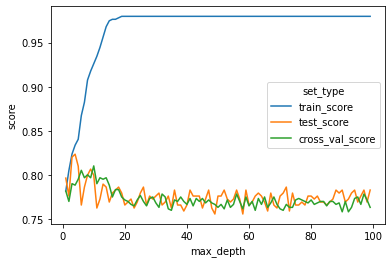

In [83]:
# Снова при помощи melt и отрисовки графика отрисуем линии. Так же добавим cross_val_score
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'],
                           value_vars=['train_score', 'test_score', 'cross_val_score'],
                           var_name='set_type',  # Имя колонки с ключами
                           value_name='score')  #
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

In [84]:
scores_data_long.query("set_type == 'cross_val_score'").head(20)
# Можем увидеть что на 11-м шаге наибольшая точность достигается

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.788627
202,5,cross_val_score,0.795350
203,6,cross_val_score,0.805434
204,7,cross_val_score,0.797017
205,8,cross_val_score,0.800364
206,9,cross_val_score,0.796989
207,10,cross_val_score,0.810434


In [85]:
# теперь при максимальной глубине 10 протестим финально дерево.
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [86]:
# проверим точность на значениях которые не видел классификатор ранее
cross_val_score(clf, X_test, y_test, cv=5).mean()
# Полученное значение можно использовать как финальное значение, которое мы получили при обучении с использованием кросс валидации на train множестве.

0.7966101694915255

In [87]:
# GridSearchCV помогает подбирать оптимальные гиперпараметры автоматом
from sklearn.model_selection import GridSearchCV

In [88]:
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30)}

In [89]:
clf = tree.DecisionTreeClassifier()
grid_search_cv_clf = GridSearchCV(clf,  parameters, cv=5)

In [90]:
grid_search_cv_clf

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [91]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [92]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 6}

In [93]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [94]:
best_clf.score(X_test, y_test)

0.7694915254237288

In [99]:
from sklearn.metrics import precision_score, recall_score

In [97]:
y_pred = best_clf.predict(X_test)
precision_score(y_test, y_pred)

0.8023255813953488

In [100]:
recall_score(y_test, y_pred)

0.575

In [101]:
# посмотрим предсказанную вероятность которую получает дерево при обучении
y_predicted_prob = best_clf.predict_proba(X_test)

In [103]:
y_predicted_prob
# Тут можем наблюдать вероятности, в отличие от y_pred, где нули и единицы и отсечка по умолчанию происходит по вероятности 0.5

array([[0.88518519, 0.11481481],
       [0.88518519, 0.11481481],
       [0.88518519, 0.11481481],
       [0.        , 1.        ],
       [0.65625   , 0.34375   ],
       [1.        , 0.        ],
       [0.23809524, 0.76190476],
       [0.88518519, 0.11481481],
       [0.23809524, 0.76190476],
       [0.        , 1.        ],
       [0.125     , 0.875     ],
       [0.88518519, 0.11481481],
       [1.        , 0.        ],
       [0.88518519, 0.11481481],
       [0.88518519, 0.11481481],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.65625   , 0.34375   ],
       [0.88518519, 0.11481481],
       [1.        , 0.        ],
       [0.88518519, 0.11481481],
       [0.60714286, 0.39285714],
       [0.65625   , 0.34375   ],
       [0.88518519, 0.11481481],
       [0.88518519, 0.11481481],
       [0.6       , 0.4       ],
       [0.60714286, 0.39285714],
       [0.88518519, 0.11481481],
       [0.6       , 0.4       ],
       [0.65625   , 0.34375   ],
       [0.

<AxesSubplot:>

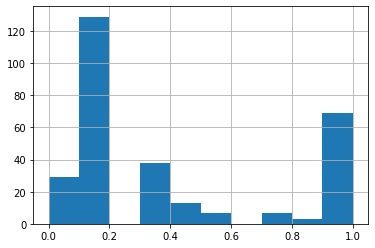

In [104]:
pd.Series(y_predicted_prob[:, 1]).hist()

In [106]:
# Попробуем сделать другую отсечку, например по 0.8
y_pred = np.where(y_predicted_prob[:, 1] > 0.8, 1, 0)

In [107]:
precision_score(y_test, y_pred)
# Точность повысилась

0.8611111111111112

In [109]:
recall_score(y_test, y_pred)
# А recall упал

0.5166666666666667

In [111]:
pd.Series(y_predicted_prob[:, 1]).nunique()
# Показывает что множество значений не бесконечно

11

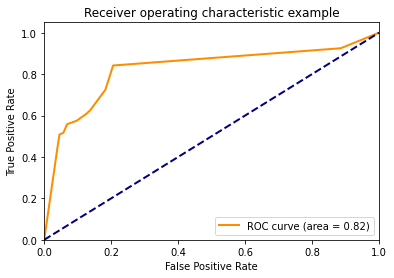

In [112]:
# Рок кривая показывает какой процент выживших мы действительно классифицировали как выжившие и то для какого процента пассажиров с отрицательным классом мы дали неправильный ответ.
from sklearn.metrics import roc_curve, auc
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()